# Hearbet Sound Anomaly Detector - EDA

Dataset provided originally by Peterjbentleky Challenge (https://istethoscope.peterjbentley.com/heartchallenge/index.html)

## Getting data

In [1]:
import pandas as pd
from pathlib import Path

In [2]:
AUDIO_DIR = Path('../unzipped_data/')

In [3]:
set_a = pd.read_csv(AUDIO_DIR.joinpath('set_a.csv'))
set_b = pd.read_csv(AUDIO_DIR.joinpath('set_b.csv'))

print('set_a', set_a.shape)
print('set_b', set_b.shape)

set_a (176, 4)
set_b (656, 4)


In [4]:
set_a.head()

,dataset,fname,label,sublabel
0,a,set_a/artifact__201012172012.wav,artifact,NaN
1,a,set_a/artifact__201105040918.wav,artifact,NaN
2,a,set_a/artifact__201105041959.wav,artifact,NaN
3,a,set_a/artifact__201105051017.wav,artifact,NaN
4,a,set_a/artifact__201105060108.wav,artifact,NaN


`nan` values corresponding to unexisting files

In [5]:
set_a.isna().sum()

dataset       0
fname         0
label        52
sublabel    176
dtype: int64

In [6]:
set_a[set_a.label.isna()].head()

,dataset,fname,label,sublabel
124,a,set_a/__201012172010.wav,NaN,NaN
125,a,set_a/__201101051105.wav,NaN,NaN
126,a,set_a/__201101061552.wav,NaN,NaN
127,a,set_a/__201101091156.wav,NaN,NaN
128,a,set_a/__201101110659.wav,NaN,NaN


In [7]:
try:
    with open(AUDIO_DIR.joinpath('set_a/__201012172010.wav')) as f:
        print(f.read())
except Exception as e:
    print(e)

[Errno 2] No such file or directory: '..\\unzipped_data\\set_a\\__201012172010.wav'


## File categorization and Dataframe creation

These are inconsistences with the file names in `set_a` and may probably be present in `set_b` dataset. Therefore, these datasets are unstrustworthy. The best approach here is to iterate accross the directories and create a new dataframe with the true file names.wah

In [8]:
set(set_a.label) | set(set_b.label)

{'artifact', 'extrahls', 'extrastole', 'murmur', nan, 'normal'}

In [9]:
def list_files():
    for file in AUDIO_DIR.glob('**/*.wav'):
        yield file.as_posix()

def create_dataset():     
    data_files = []
    for filename in list_files():
        if filename.find('artifact')>-1:
            data_files.append((filename, 'artifact'))
        if filename.find('extrahls')>-1:
            data_files.append((filename, 'extrahls'))
        if filename.find('extrastole')>-1:
            data_files.append((filename, 'extrastole'))
        if filename.find('murmur')>-1:
            data_files.append((filename, 'murmur'))
        if filename.find('normal')>-1:
            data_files.append((filename, 'normal'))
    
    return pd.DataFrame(data_files, columns=('fname', 'label'))

In [10]:
%%time

audio_data = create_dataset()

CPU times: total: 15.6 ms
Wall time: 21 ms


In [11]:
audio_data.head()

,fname,label
0,../unzipped_data/set_a/artifact__201012172012.wav,artifact
1,../unzipped_data/set_a/artifact__201105040918.wav,artifact
2,../unzipped_data/set_a/artifact__201105041959.wav,artifact
3,../unzipped_data/set_a/artifact__201105051017.wav,artifact
4,../unzipped_data/set_a/artifact__201105060108.wav,artifact


In [12]:
audio_data.label.value_counts()

label
normal        351
murmur        129
extrastole     46
artifact       40
extrahls       19
Name: count, dtype: int64

Checking number of files:

In [12]:
# Pythonic way

audio_data.shape[0]

585

In [13]:
%%time

# With bash command

!ls -1 ../unzipped_data/**/*.wav | grep -v unlabelled | wc -l

CPU times: total: 31.2 ms
Wall time: 31 ms


No se esperaba & en este momento.


Removing unused variables to free memory resources

In [14]:
del set_a, set_b

## Types of Hearbetsounds 

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

<BarContainer object of 5 artists>

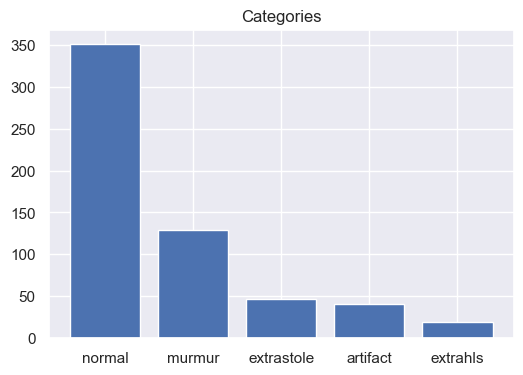

In [16]:
count_labels = audio_data.label.value_counts()

sns.set()
plt.figure(figsize=(6, 4))
plt.title('Categories')
plt.bar(count_labels.index, count_labels.values)

To deal with this class imbalance I will need some data augmentations or distribute the weights when it comes to train the neural network

## Reproducing audio files

In [17]:
from IPython.display import Audio, display
import torchaudio
import librosa

I will try to reproduce a random recording for each group

In [18]:
recording_by_group = audio_data.groupby('label').sample().reset_index()
recording_by_group

,index,fname,label
0,28,../unzipped_data/set_a/artifact__201106131835.wav,artifact
1,51,../unzipped_data/set_a/extrahls__201103150114.wav,extrahls
2,134,../unzipped_data/set_b/extrastole__153_1306848...,extrastole
3,230,../unzipped_data/set_b/murmur__197_13081412355...,murmur
4,376,../unzipped_data/set_b/normal_noisynormal_271_...,normal


In [19]:
def load_audio_from_groupby():
    for item in recording_by_group.itertuples():
        y, sr = torchaudio.load(item.fname)
        yield (item.label.title(), item.fname), (y, sr)

In [20]:
for (label, fname), (_, sr) in load_audio_from_groupby():
    print('Label:', label, '- Path:', fname)
    display(Audio(fname, rate=sr))

Label: Artifact - Path: ../unzipped_data/set_a/artifact__201106131835.wav


Label: Extrahls - Path: ../unzipped_data/set_a/extrahls__201103150114.wav


Label: Extrastole - Path: ../unzipped_data/set_b/extrastole__153_1306848820671_C.wav


Label: Murmur - Path: ../unzipped_data/set_b/murmur__197_1308141235553_A.wav


Label: Normal - Path: ../unzipped_data/set_b/normal_noisynormal_271_1309369876160_A.wav


## Reading audio files with Torchaudio and Librosa

In [21]:
import torch
from typing import Callable, Tuple

### Plotting spectograms

In [22]:
def plot_waveform(waveform: torch.Tensor, sr: float, title: str='Waveform', ax=None):
    waveform = waveform.numpy()

    _, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr
    if ax==None:
        _, ax = plt.subplots(1,1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title, fontsize=9)
    ax.tick_params(axis='both', labelsize=8)

def plot_spectrogram(transform_fn: Callable, waveform: torch.Tensor, title: str = 'Spectrogram', figsize: Tuple = None, ax = None):
    spect_db = transform_fn(waveform)
    if ax==None:
        _, ax = plt.subplots(1, 1, figsize = figsize)
    ax.imshow(librosa.power_to_db(spect_db[0]), interpolation='nearest', origin='lower', aspect='auto', cmap='viridis')
    ax.set_title(title, fontsize=9)
    ax.grid(False)
    ax.tick_params(axis='both', labelsize=8)

### Plotting waveforms and spectrograms for each category

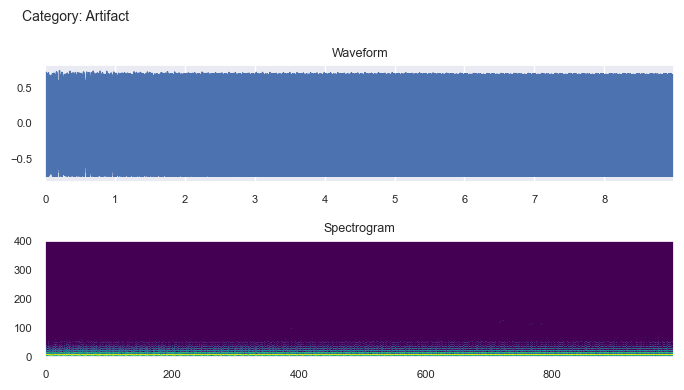

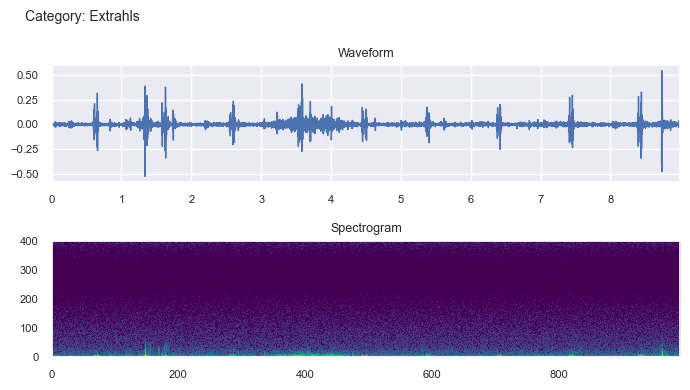

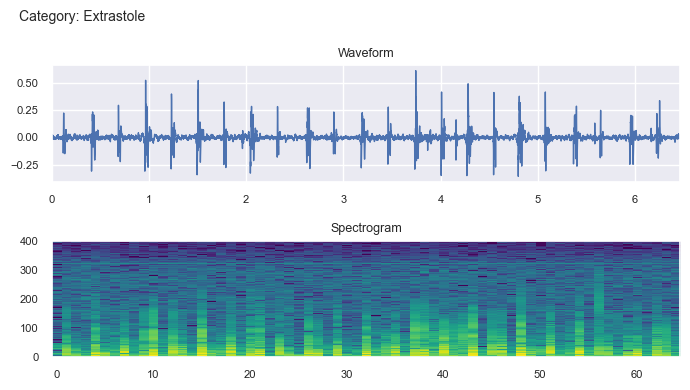

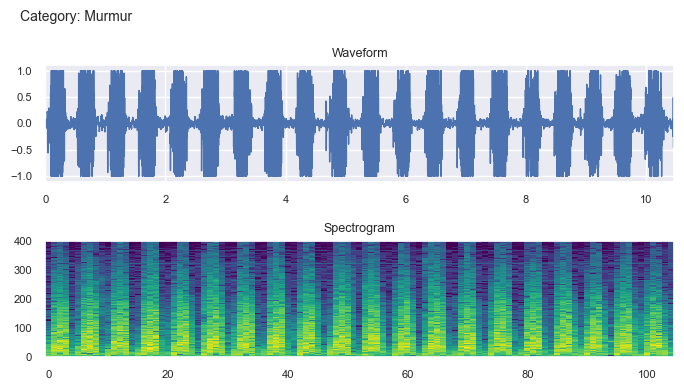

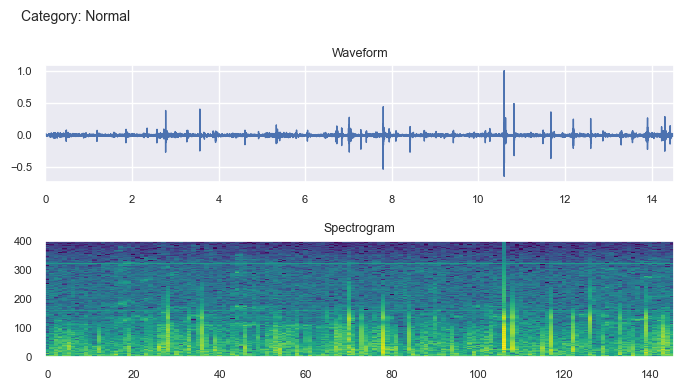

CPU times: total: 29.5 s
Wall time: 27.5 s


In [23]:
%%time

transform = torchaudio.transforms.Spectrogram(n_fft=800)

for ((label, _), (y, sr)) in load_audio_from_groupby():

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 4))
    plt.subplots_adjust(hspace=.3)
    plot_waveform(waveform=y, sr=sr, ax=ax1)

    plot_spectrogram(transform, y, ax=ax2)
    plt.suptitle(f'Category: {label}', x=0.12, y=0.97, fontsize=10)
    fig.tight_layout()

    plt.show()

## Exploring Sample rates and duration of sounds

### Duration

In [24]:
def get_durations(row):
    waveform, sr = torchaudio.load(row.fname)
    duration: float = librosa.get_duration(y=waveform, sr=sr)
    return duration, sr      

In [25]:
%%time

audio_data[['duration', 'sr']] = audio_data.apply(get_durations, axis=1, result_type='expand')

CPU times: total: 797 ms
Wall time: 4.51 s


In [26]:
audio_data.head()

,fname,label,duration,sr
0,../unzipped_data/set_a/artifact__201012172012.wav,artifact,9.0,44100.0
1,../unzipped_data/set_a/artifact__201105040918.wav,artifact,9.0,44100.0
2,../unzipped_data/set_a/artifact__201105041959.wav,artifact,9.0,44100.0
3,../unzipped_data/set_a/artifact__201105051017.wav,artifact,9.0,44100.0
4,../unzipped_data/set_a/artifact__201105060108.wav,artifact,9.0,44100.0


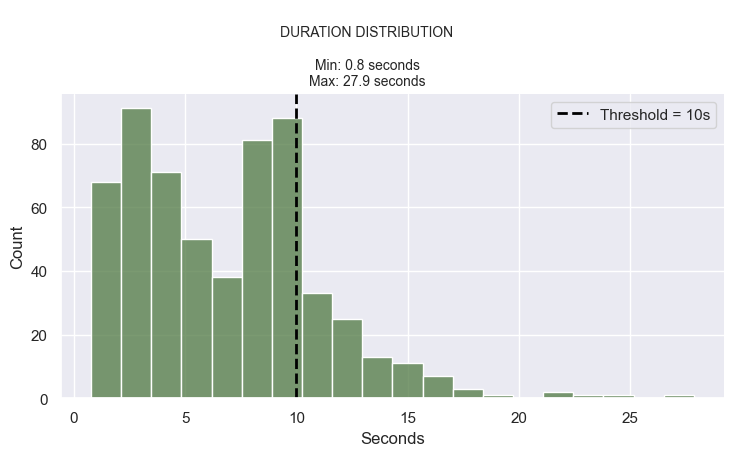

In [28]:
sns.displot(audio_data.duration, color='#4F7942', bins=20, height= 5, aspect=1.5)

THRESHOLD: int = 10

plt.axvline(THRESHOLD, ls='--', lw=2, label=f'Threshold = {THRESHOLD}s', c='black')

suptitle: str = f'''
DURATION DISTRIBUTION

Min: {audio_data.duration.min():.1f} seconds
Max: {audio_data.duration.max():.1f} seconds
'''

plt.suptitle(suptitle, fontsize=10, y=0.91)
plt.xlabel('Seconds')
plt.ylabel('Count')
plt.legend()
plt.subplots_adjust(top=0.74)
plt.show()

### Sample rate

In [28]:
audio_data.sr.value_counts(normalize=True)

sr
4000.0     0.788034
44100.0    0.211966
Name: proportion, dtype: float64

78.8% of the audio files have a sample rate of 4000, this value could be used to resample the rest of audio recordings.


In [29]:
audio_data.groupby(['label', 'sr'])['sr'].count()

label       sr     
artifact    44100.0     40
extrahls    44100.0     19
extrastole  4000.0      46
murmur      4000.0      95
            44100.0     34
normal      4000.0     320
            44100.0     31
Name: sr, dtype: int64

Most of the normal hearbetsounds have a sample rate of 4000

<Axes: xlabel='sr', ylabel='duration'>

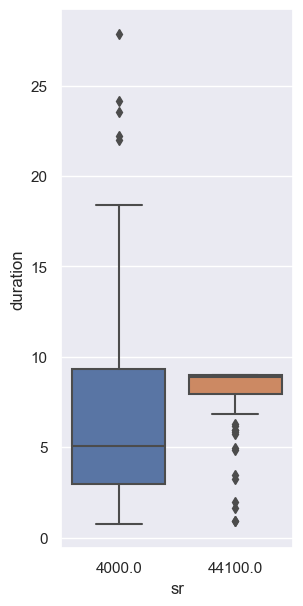

In [30]:
plt.figure(figsize=(3, 7))
sns.boxplot(audio_data, x='sr', y='duration')

Notice that sample rate is inversely proportional the audio duration. The sample rate represents the number of samples of audio taken per second, and the audio duration is the length of the audio in seconds.   
This relationship can be expressed as follows.

$$ \text{Audio Duration (seconds)} = \frac{N}{SR} $$


## Data Augmentation

Because there is an apparent unbalanced class, I will apply the most popular data augmentation techniques according the state-of-the-art:

* `FrequencyMasking`: Apply masking to a spectrogram in the frequency domain.

* `TimeMasking`: Apply masking to a spectrogram in the time domain.

* `TimeStretch`: Stretch stft in time without modifying pitch for a given rate.

In [31]:
import torchaudio.transforms as T

In [36]:
filename: str = recording_by_group.query('label=="extrahls"').fname.values[0]

print(f'{filename=}')

waveform, sr = torchaudio.load(filename, normalize=True)

filename='../unzipped_data/set_a/extrahls__201104270458.wav'


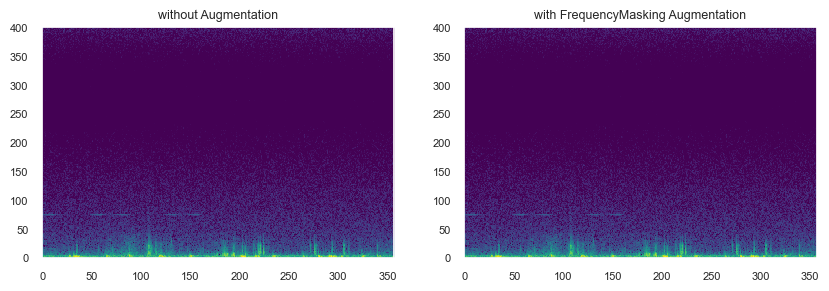

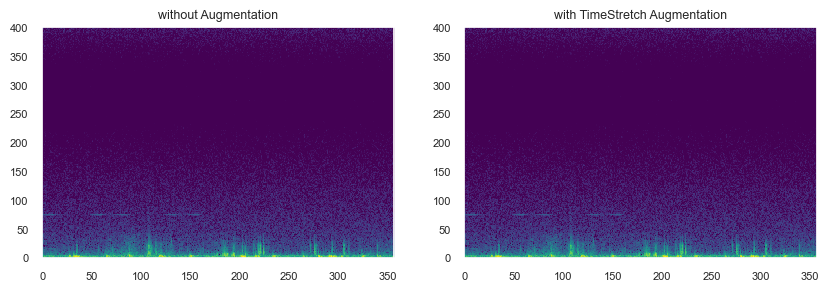

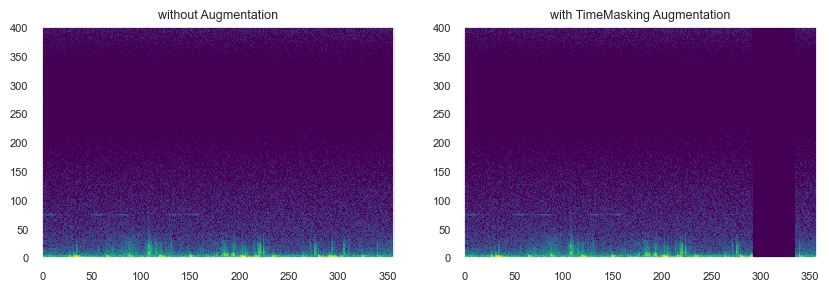

In [34]:
transformation_classes = (
    T.FrequencyMasking(freq_mask_param=10),
    T.TimeStretch(.8, fixed_rate=True),
    T.TimeMasking(time_mask_param=80)
)

def plot_augmentations(transform_classes):
    spec_transform = T.Spectrogram(n_fft=800)

    for transform_class in transform_classes:
        _, (ax1, ax2) = plt.subplots(1,2, figsize = (10, 3))

        plot_spectrogram(spec_transform,
                        waveform,
                        title='without Augmentation',
                        ax=ax1)

        transform_fn: Callable = lambda waveform: transform_class(spec_transform(waveform))

        plot_spectrogram(transform_fn,
                        waveform,
                        title=f'with {transform_class.__class__.__name__} Augmentation',
                        ax=ax2)

plot_augmentations(transformation_classes)